In [13]:
#%matplotlib widget
%pylab inline
from matplotlib.pylab import *
datafile = "data.npz"
import numpy as np

Populating the interactive namespace from numpy and matplotlib


C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'linalg', 'power', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
o = np.load(datafile)
im = o["image"]
upx, upy = o["upperlimit"]
lox, loy = o["lowerlimit"]

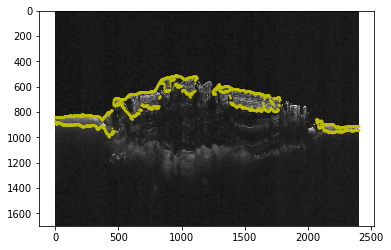

In [14]:
#figure(figsize=(20,10))
imshow(im)
plt.scatter(upy,upx, c='y', s=1)
plt.scatter(loy,lox, c='y', s=1)
# plt.scatter(loy[602],lox[602], c='r', s=50)
# plt.scatter(upy[602],upx[602], c='r', s=50)

In [4]:
# we want to analyze a full segment of the layered body
start, end = 1400, 1640 # start and end column

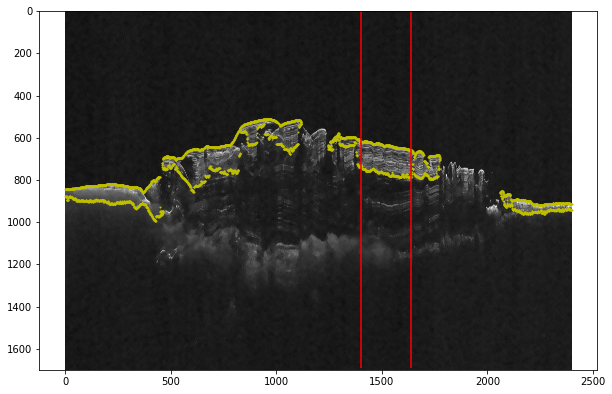

In [15]:
figure(figsize=(10,10))
imshow(im)
plt.scatter(upy,upx, c='y', s=1)
plt.scatter(loy,lox, c='y', s=1)

vlines([start, end], 0, 1690, 'r')

In [6]:
from attr import ib, attrs
@attrs
class TimeSerie():
    signal = ib()
    start = ib()
    end = ib()
    column = ib()
    


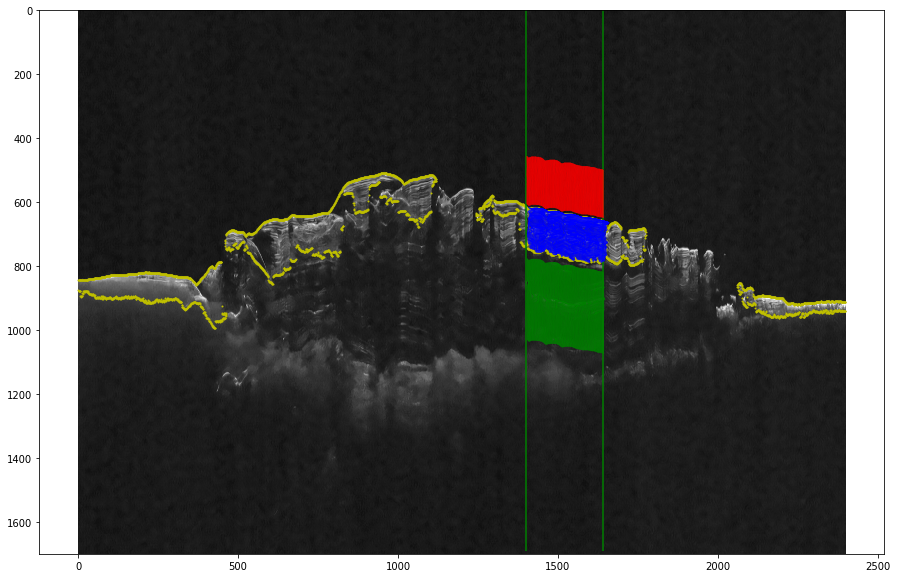

In [38]:
# now we extract the timeseries, also a plot just to be sure of what we are doing

figure(figsize=(20,10))
imshow(im)
gray()
series = []
noises = []    #taken in a region over the cap where no signal is expected
seriesdeep = []

nlength = 150 # lenght of ts for noise
buf = 10

for i, colid in enumerate(np.arange(start, end)):
#     print(f"column {colid}")
    if colid not in upy:
#         print("not")
        continue
        
    col_pos_in_list = np.where(colid == upy)[0][0]
        
    astart = upx[col_pos_in_list] #raw value where the signal selected region begins for each column
    aend = lox[col_pos_in_list]
#     print(astart, aend)
    
    ts = im.T[colid][astart:aend]
    
    plt.plot(ts*0.1+colid, np.arange(len(ts))+astart+1, color="b", linewidth=0.5)
    
    nstart = astart-nlength - buf  #region over the cap between the column limits start and end
    nend = astart-buf
    
    no = im.T[colid][nstart:nend]
    
    plt.plot(no*0.1+colid, np.arange(len(no))+nstart+1, color="r", linewidth=0.5)
    
    dstart = astart+nlength + buf  #region over the cap between the column limits start and end
    dend = dstart+int(1.7*nlength)
    
    dts = im.T[colid][dstart:dend]
    
    plt.plot(dts*0.1+colid, np.arange(len(dts))+dstart+1, color="g", linewidth=0.5)
    
    series.append(TimeSerie(signal=ts, start=astart, end=aend, column=colid))
    noises.append(TimeSerie(signal=no, start=nstart, end=nend, column=colid))
    seriesdeep.append(TimeSerie(signal=dts, start=dstart, end=dend, column=colid))
    
# gca().set_ylim(gca().get_ylim()[::-1])

plt.scatter(upy,upx, c='y', s=1)
plt.scatter(loy,lox, c='y', s=1)

vlines([start, end], 0, 1690, 'g')

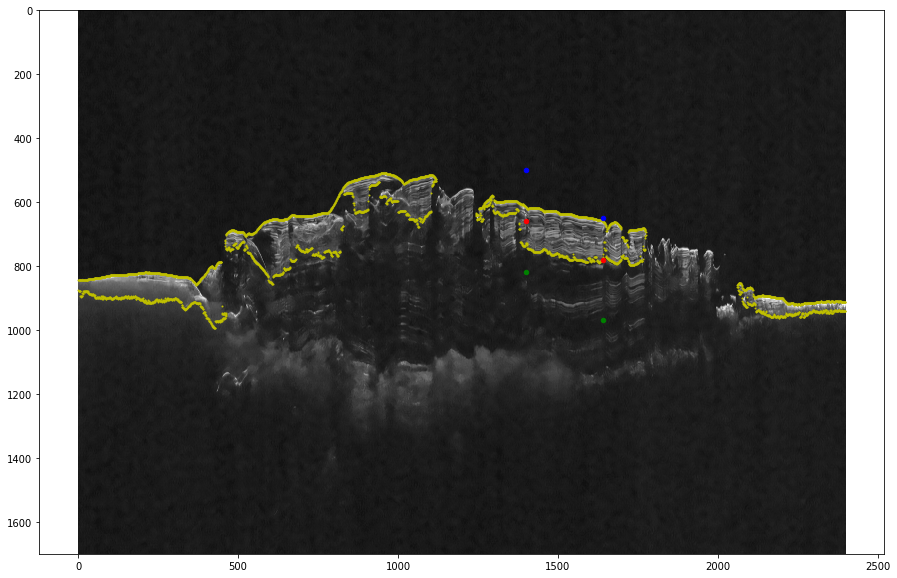

In [32]:
figure(figsize=(20,10))
imshow(im)

plt.scatter(upy,upx, c='y', s=1)
plt.scatter(loy,lox, c='y', s=1)

plt.scatter(start, dstart, c='g', s=20)
plt.scatter(end, dend, c='g', s=20)

plt.scatter(start, astart, c='r', s=20)
plt.scatter(end, aend, c='r', s=20)

plt.scatter(start, nstart, c='b', s=20)
plt.scatter(end, nend, c='b', s=20)

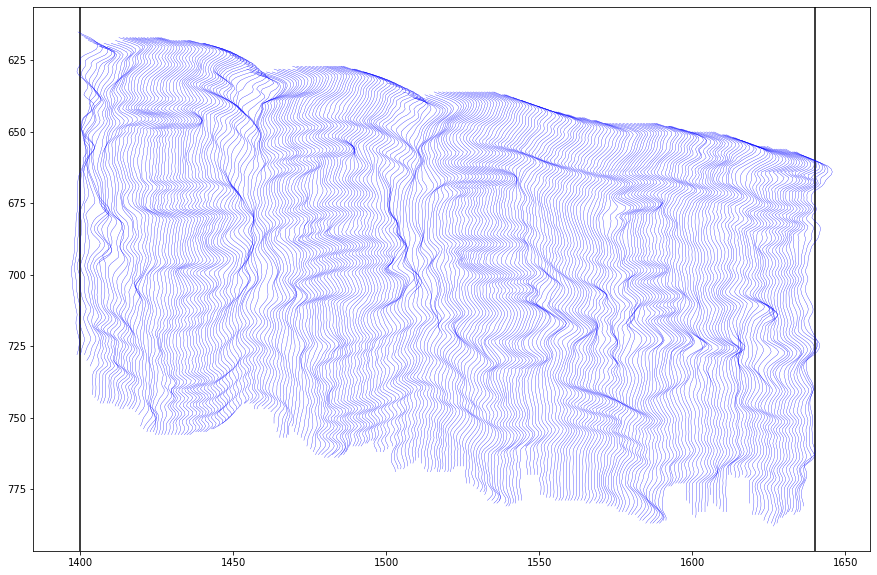

In [39]:
# test a wiggle plot, it highlights the horizons, often used in seismic data
#each curve is the time series of a column (grey value in function of pixel depht, intensity curve)

#it is necessary to shift each curve to visualize properly
#each curve is normalized

figure(figsize=(15,10))
for ts in series:
    
    s = ts.signal - np.mean(ts.signal)
    s /= np.std(s)
    
    plot(s*2+ts.column, np.arange(len(s))+ts.start, color="b", linewidth=0.3)
    
gca().set_ylim(gca().get_ylim()[::-1])


vlines([start, end], 0, 1600)

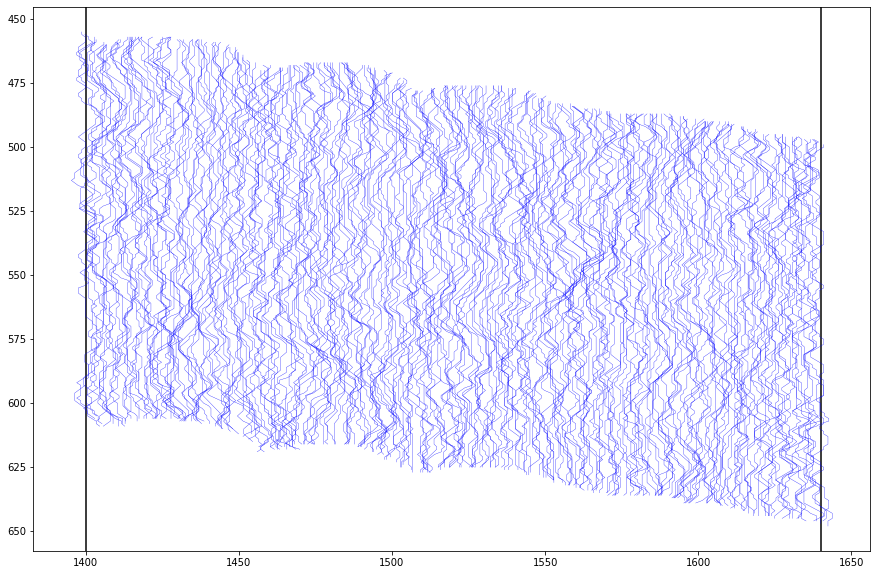

In [40]:
# test a wiggle plot of noise, it highlights the horizons, often used in seismic data, these are examples of noise

figure(figsize=(15,10))
for ts in noises:
    
    s = ts.signal - np.mean(ts.signal)
    s /= np.std(s)
    
    plot(s*2+ts.column, np.arange(len(s))+ts.start, color="b", linewidth=0.3)
    
gca().set_ylim(gca().get_ylim()[::-1])


vlines([start, end], 0, 1600)

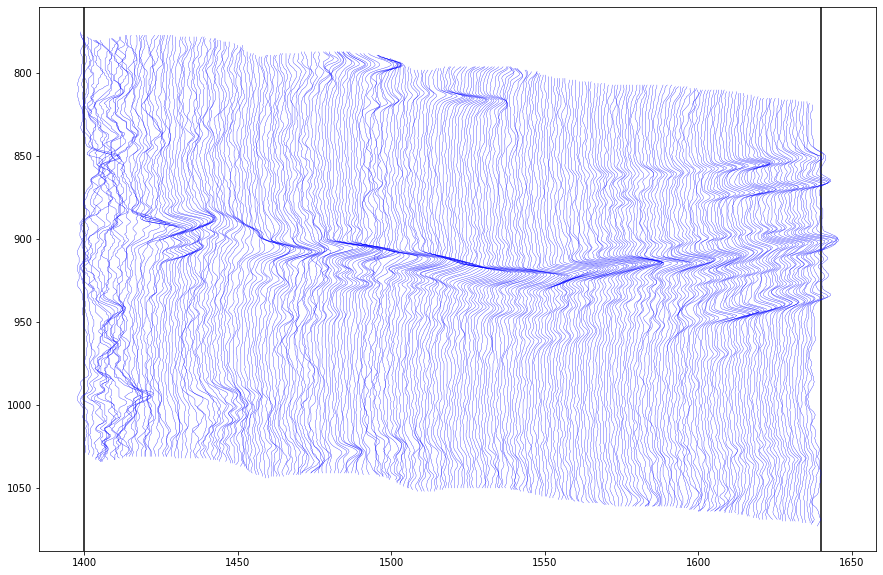

In [41]:
# test a wiggle plot of the signal in the deeper part, it highlights the horizons, often used in seismic data, these are examples of noise

figure(figsize=(15,10))
for ts in seriesdeep:
    
    s = ts.signal - np.mean(ts.signal)
    s /= np.std(s)
    
    plot(s*2+ts.column, np.arange(len(s))+ts.start, color="b", linewidth=0.3)
    
gca().set_ylim(gca().get_ylim()[::-1])


vlines([start, end], 0, 1600)

In [43]:
from scipy.signal import periodogram, get_window, detrend, find_peaks, find_peaks_cwt
padto =10000  #length to which each column will be extended with zeros
powers = []

for n in noises:
    
    w = get_window("hamming", len(n.signal))
    
    signal = detrend(n.signal, type="linear")  
    #removes the linear trend (spectral zero frequency is not interesting in this case)
    
    signal = signal*w
    
    padded = np.pad(signal, (0, padto-len(n.signal)))   #fictitious aumentation of the signal (adding zeros tho reach padto length)
    f, p = periodogram(padded, detrend="linear", fs =1) # fs should be set to a sampling frequency that makes sense e.g. time
    powers.append(p)
    #print(len(powers))
print(type(powers))   
noise_f = f
avg_p_noise  = np.mean(np.row_stack(powers), axis=0) # the averagepower spectrum of the noise, to have a reference

<class 'list'>


In [19]:
print(len(powers[200]))
print(type(avg_p_noise))

5001
<class 'numpy.ndarray'>


In [44]:
ci95 = np.percentile(powers, 99.9, axis=0)

In [64]:
print (ci95)

[2.75722253e-30 2.91211592e+00 1.83764912e+00 ... 5.99149094e-03
 5.99433852e-03 2.99764406e-03]


In [45]:
# now the same for the signals
padto =10000
powers = []
for n in series:
    w = get_window("hamming", len(n.signal))
    signal = detrend(n.signal, type="linear")
    
    signal = signal*w
    padded = np.pad(signal, (0, padto-len(n.signal)))
    
    f, p = periodogram(padded, detrend=False, fs =1) # fs should be set to a sampling frequency that makes sense e.g. time step of the radar signal
    powers.append(p)
    
signal_f = f
avg_p_signals  = np.mean(np.row_stack(powers), axis=0) # the average power spectrum of the noise, to have a reference

In [47]:
# now the same for the signals in the deeper part
padto =10000
powersd = []
for n in seriesdeep:
    w = get_window("hamming", len(n.signal))
    signal = detrend(n.signal, type="linear")
    
    signal = signal*w
    padded = np.pad(signal, (0, padto-len(n.signal)))
    
    fd, pd = periodogram(padded, detrend=False, fs =1) # fs should be set to a sampling frequency that makes sense e.g. time step of the radar signal
    powersd.append(pd)
    
signal_deep_f = fd
avg_p_signalsdeep  = np.mean(np.row_stack(powersd), axis=0) # the average power spectrum of the noise, to have a reference

In [48]:
lengths = []
for n in series:
    lengths.append(len(n.signal))
    
import scipy
scipy.stats.describe(lengths) # we have a look at the lengths of the signals we are analyzing, theygo from 100 to 150, average is 132

DescribeResult(nobs=240, minmax=(112, 145), mean=132.09166666666667, variance=47.01248256624826, skewness=-0.7185013165205091, kurtosis=0.28940896942435357)

array([ 119,  435,  597,  723, 1209, 1583, 2028, 2173, 2633, 2845, 2962,
       3207, 3361, 3558, 3724, 3923, 4034, 4216, 4256, 4371, 4495, 4593,
       4926])

In [49]:
def plot_peaks(freqs, power):
    peaks = find_peaks(power)[0]
    tt = ['{:6.2f}'.format(1/val) for val in freqs[peaks]]

    for s, p, t in zip(freqs[peaks], power[peaks], tt):
        text(s,p,t)
        
    return peaks, tt

(0, 0.55)

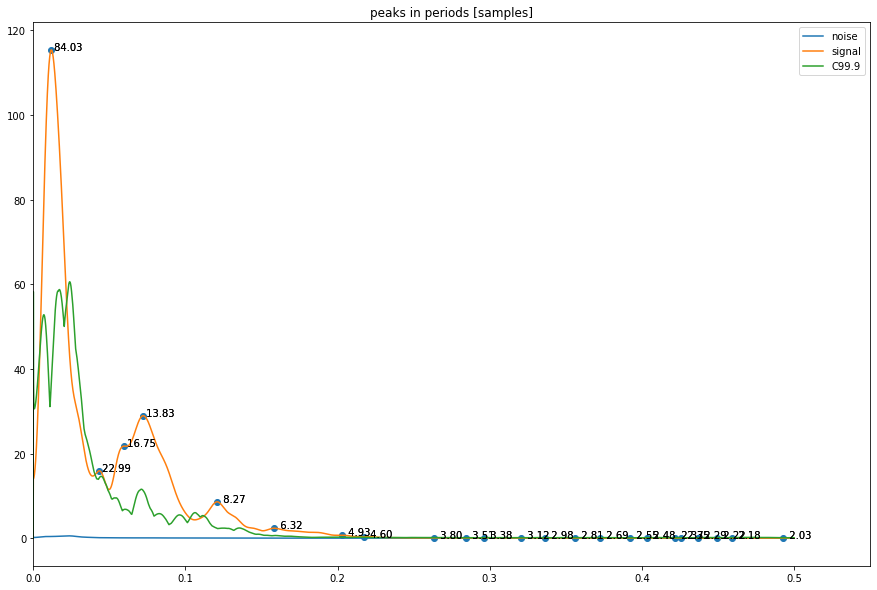

In [103]:
figure(figsize=(15,10))
plot(noise_f, avg_p_noise, label="noise")
plot(signal_f, avg_p_signals, label="signal")
plot(noise_f, ci95*20, label="C99.9")

peaks = plot_peaks(signal_f, avg_p_signals)[0]
tt = plot_peaks(signal_f, avg_p_signals)[1]

scatter(signal_f[peaks], avg_p_signals[peaks])
    
title("peaks in periods [samples]")
legend()
xlim(0, 0.55)

The peaks are at 84, 14, and 8, meaning good potion of the spectral energy is concentrated around these bands.
84 is not so far from the average lengths of the signals (134) making it impossible to establish if it is noise or not
but the 14/17 and 8 might be real. In particular around 8 might be the main layering, which would seem to be organized in boundles of largest length, around 15)
We now try to better attribute these features to the signal, as example we use the column 1530

(0, 0.55)

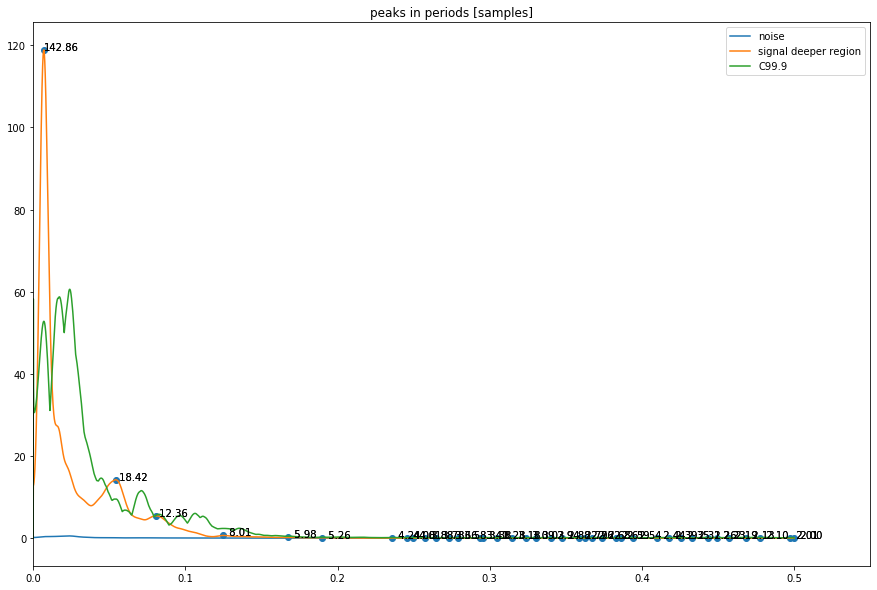

In [50]:
#deeper region

figure(figsize=(15,10))
plot(noise_f, avg_p_noise, label="noise")
plot(signal_deep_f, avg_p_signalsdeep, label="signal deeper region")
plot(noise_f, ci95*20, label="C99.9")

peaksdeep = plot_peaks(signal_deep_f, avg_p_signalsdeep)[0]
ttdeep = plot_peaks(signal_deep_f, avg_p_signalsdeep)[1]

scatter(signal_deep_f[peaksdeep], avg_p_signalsdeep[peaksdeep])
    
title("peaks in periods [samples]")
legend()
xlim(0, 0.55)

In [117]:
from ConnectedComp import Conversion

print('Peaks:',peaks)
print()
print ('avg_p_signals[peaks]:', avg_p_signals[peaks])
print()
print('tt:', tt)
print()
#pxfreq = [float(i) for i in tt]
pxfreq = np.zeros(len(tt))
for i in range(len(tt)):
    pxfreq[i]= float(tt[i])
    
print('Significative Pixel Frequencies:', pxfreq[3], pxfreq[4])
print()
freqsec, freqkm, freqm = Conversion(pxfreq)
print()
print('Significative Frequencies in meters:', freqm[3], freqm[4])
print()
print('Significative Frequencies ratios', freqm[3]/freqm[4], freqm[4]/freqm[3] )

Peaks: [ 119  435  597  723 1209 1583 2028 2173 2633 2845 2962 3207 3361 3558
 3724 3923 4034 4216 4256 4371 4495 4593 4926]

avg_p_signals[peaks]: [1.15406269e+02 1.59111033e+01 2.17408404e+01 2.89389098e+01
 8.58673479e+00 2.35347705e+00 7.03307387e-01 3.67802720e-01
 7.44869564e-02 4.87044387e-02 4.09683891e-02 1.77858218e-02
 1.52867774e-02 9.27831643e-03 7.32388017e-03 7.62892865e-03
 6.25662318e-03 5.36514845e-03 5.38046854e-03 4.97358485e-03
 4.43376311e-03 5.15073961e-03 3.65350280e-03]

tt: [' 84.03', ' 22.99', ' 16.75', ' 13.83', '  8.27', '  6.32', '  4.93', '  4.60', '  3.80', '  3.51', '  3.38', '  3.12', '  2.98', '  2.81', '  2.69', '  2.55', '  2.48', '  2.37', '  2.35', '  2.29', '  2.22', '  2.18', '  2.03']

Significative Pixel Frequencies: 13.83 8.27

Thickness [sec] [3.151125e-06 8.621250e-07 6.281250e-07 5.186250e-07 3.101250e-07
 2.370000e-07 1.848750e-07 1.725000e-07 1.425000e-07 1.316250e-07
 1.267500e-07 1.170000e-07 1.117500e-07 1.053750e-07 1.008750e-07
 9.5

In [28]:
for ts in series: # search the corresponding signal
    if ts.column == 1530:
        selected = ts
    

array([ 2,  4,  6,  8, 10, 13, 17, 20, 22, 26, 31, 33, 37, 42, 47, 51, 56,
       59, 63, 68], dtype=int64)

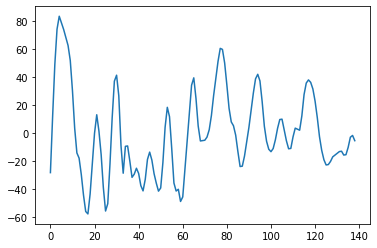

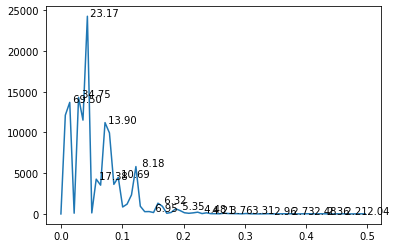

In [29]:
figure()
s = selected.signal
s = detrend(s, type="linear")
plot(s)

f, p = periodogram(s)
figure()
plot(f,p)

plot_peaks(f,p)

We see that we have again 6, 8, 14 and 23 as main periods, might they be all harmonics? It would be interesting to create a fake signal to test what kind of harmonics one get out of them
we try to filter out these components to see what they represent

In [30]:
from scipy import fftpack

In [31]:
def fft_bandpass_filter(s, interval, time_step=1):
    signal_fft = fftpack.fft(s)

    # The corresponding frequencies
    freqs = fftpack.fftfreq(s.size, d=time_step)

    copy = np.zeros(freqs.size)

    low, high = interval
    slotfreqs = np.logical_and(np.abs(freqs) > low, np.abs(freqs) < high)
    copy[slotfreqs] = signal_fft[slotfreqs]

    filtered_signal = fftpack.ifft(copy)
    return filtered_signal

def fft_bandpass_filter_multibands(s, intervals, time_step = 1):
    signal_fft = fftpack.fft(s)

    # The corresponding frequencies
    freqs = fftpack.fftfreq(s.size, d=time_step)

    copy = np.zeros(freqs.size)

    for low, high in intervals:
        slotfreqs = np.logical_and(np.abs(freqs) > low, np.abs(freqs) < high)
        copy[slotfreqs] = signal_fft[slotfreqs]

    filtered_signal = fftpack.ifft(copy)
    return filtered_signal

In [32]:
ints = [(0.038, 0.048), (0.065, 0.085), (0.114, 0.133), (0.149, 0.175)]

f = fft_bandpass_filter_multibands(s, time_step=1, intervals=ints) #time step should be changed to something more meaningful, as earlier in this notebook

C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added

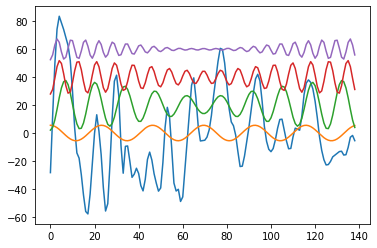

In [33]:
figure()

plot(s)

for i, inte in enumerate(ints):
    ss = fft_bandpass_filter(s, inte, 1 )
    plot(ss+i*20)

In [35]:
# we use an R package called astrochron for the speectral estimates, it might not be really straighforward
# install R, then open an R console by calling "R" in the command line
# now we install the librarby we will need "install.packages("astrochron")"
# might not work at all on windows


import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
numpy2ri.activate()


In [ ]:
# next to be finished/evaluated for the future

In [50]:
from rpy2.robjects.packages import importr
utils = importr('utils')
# utils.chooseCRANmirror(ind=1)
utils.install_packages('astrochron')

rpy2.rinterface.NULL

In [51]:
from rpy2.robjects.packages import importr
ac = importr("astrochron")



In [52]:
s = series[10].signal

dat = np.column_stack([np.arange(len(s)), s])
power = ac.mtmML96(dat, linLog=2, output=1, genplot=False, detrend=True, demean=True, padfac=20)

In [53]:
f = power["Frequency"]
p = power["Power"]
figure()
plot(f, p)
xlim(0, 0.2)

TypeError: SexpVector indices must be integers, not str

In [36]:
ac.mtmML96?

Signature:       ac.mtmML96(*args, **kwargs)
Type:            DocumentedSTFunction
String form:    
function (dat, tbw = 3, ntap = NULL, padfac = 5, demean = T,
           detrend = F, medsmooth = 0.2, o <...> "
           return(sigfreq)
           }
           }
           <bytecode: 0x55bbce163f80>
           <environment: namespace:astrochron>
           
File:            /usr/lib/python3.8/site-packages/rpy2/robjects/functions.py
Docstring:      
Python representation of an R function.
description
-----------


 Mann and Lees (1996) robust red noise MTM analysis. This function implements several improvements to the algorithm used in SSA-MTM toolkit, including faster AR1 model optimization, and more appropriate 'edge-effect' treatment.
 


mtmML96(
    dat,
    tbw = 3.0,
    ntap = rinterface.NULL,
    padfac = 5.0,
    demean = <rpy2.rinterface.ListSexpVector object at 0x7f84063653c0> [RTYPES.VECSXP],
    detrend = <rpy2.rinterface.ListSexpVector object at 0x7f8406365dc0> [RTYPES